# Code Summary

# This notebook adheres to TRIPOD Criteria

# Preprocess Data 
    # select data (A_ variables or non-A_ variables)
    # select the label (y) and remove it from the dataset (X)
    # exclude future variables
    # exclude variables more than 50% blank
    # train/test split (80:20)
    # make a dictionary of which variables are continuous vs ordinal vs categorical
    # normalize training continuous variables to be mean centered on 0, std_dev = 1
    # keep ordinal variables as is (but map unknown or NaN to 99 or -1 or 0)
    # one-hot encoding of categorical variables
    # apply the same training normalization to test data
# Visualize data
    # Plot some initial data distributions
    # Plot covariance matrix heatmap showing which variables correlate most with outcome variables
# Train/Validate
    # Select 5 algorithms which can take normalized continuous variables and one-hot encoded categorical variables and output a probability
    # 1. XGBoost (Extreme Gradient Boosting), 2. LightGBM, 3. CatBoost, 4. Neural Networks, 5. Gradient Boosting Classifier (e.g., scikit-learn's GradientBoostingClassifier)
    # Bootstrapped nested k-fold cross-validation (100-fold bootstrap, k=5, score should be the ROC-AUC score)
    # For the nested part, select a random range of hyperparameters appropriate for each of the 5 algorithms, with 20 different hyperparameter combinations total per algorithm
    # Plot progress bars showing training progress
    # Plot one bar plot per algorithm of performance vs training param combination (thus the x-axis should have 20 ticks)
    # Print out the best hyperparameter combinations for each algorithm
    # Use stacking to get a single aggregate score based on all the 5 models with the best hyperparameter scores
    # Display Results
        # Plot ROC-AUC plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score
        # Plot bar plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score with error bars giving the 95% CI from bootstrapping
        # Convert label probability into binary label (>=0.5 = 1, <0.5 = 0)
        # Use binary labels to get accuracy, sensitivity, specificity, F1-score, and plot confusion matrix
    # Retrain the 5 models (with best hyperparams) and stacked model on the full train dataset (with progress bar)
    # Save the final trained 5 models and stacked model
# Test
    # Use the stacked model and all 5 final trained models to predict the label in the held-out test set
    # Use 100-fold bootstrapping of test set to get 95% CI
    # Display Results
        # Plot ROC-AUC plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score
        # Plot bar plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score with error bars giving the 95% CI from bootstrapping
        # Convert label probability into binary label (>=0.5 = 1, <0.5 = 0)
        # Use binary labels to get accuracy, sensitivity, specificity, F1-score, and plot confusion matrix
     

In [1]:
import wandb

# initialize project
# define config params (dict)
# log results (numbers, etc.)
# log images

In [2]:
from ent_utils import *

'''
Toggle experiment settings here
'''

# Record the start time
start_time = datetime.datetime.now()

experiment_name = "30d_mort_demo"  # Set your experiment name, if any

use_mini_dataset = False
# use_mini_dataset = True # Set to True for testing with a mini-train and test dataset (first 500 entries of each)

dataset_option = "use_full_ncbd_dataset"
# dataset_option = "use_selected_A_dataset" # Use selected A variables only

# outcome_option = "use_30_day_readmission"; class_labels = ['No Readmission','Readmission within 30 Days']; outcome_name = 'READM_HOSP_30_DAYS'
outcome_option = "use_30_day_mortality"; class_labels = ['Living','Deceased within 30 Days']; outcome_name = 'PUF_30_DAY_MORT_CD'
# outcome_option = "use_90_day_mortality"; class_labels = ['Living','Deceased within 90 Days']; outcome_name = 'PUF_90_DAY_MORT_CD'


split_by_dx_date=False
# split_by_dx_date=True # Set to True for sensitivity analysis for spliting by diagnosis date: train (early cases) vs test (late cases)

exclude_variables_more_than_x_proportion_blank = 0.5

train_test_split = [80,20]

use_lasso = True; use_rfe = False; use_rf = False; use_boruta = False; overlap_mode="all_overlap"

# use_PCA = True
use_PCA = False

n_bootstraps_for_training = 10
n_bootstraps_for_results = 100
num_k_fold_splits = 5

if use_mini_dataset:
    n_bootstraps_for_training = 2
    n_bootstraps_for_results = 5
    num_k_fold_splits = 2

In [3]:
# Load the database .sav file
df, meta = pyreadstat.read_sav("data/Aman_NCDB_ML_ONM_HNSCC_Database.sav")


In [4]:
# '''
# Show data distribution and basic statistics
# '''

# visualize_demographics(df)

# # Print out all the column names of the DataFrame
# print(df.columns.tolist())

# # Generate data summaries
# demographic_summaries, age_stats, ln_stats = summarize_demographics(df)

# print("Age Statistics:")
# display(age_stats)

# print("Lymph Node Statistics:")
# display(ln_stats)

# print("\nDemographic Summaries:")
# for key, value in demographic_summaries.items():
#     print(f"\n{key}:")
#     display(value)


In [5]:
# Preprocess Data 
    # select data (A_ variables or non-A_ variables)
    # select the label (y) and remove it from the dataset (X)
    # exclude future variables
    # exclude variables more than 50% blank
    # train/test split (80:20)
    # make a dictionary of which variables are continuous vs ordinal vs categorical
    # normalize training continuous variables to be mean centered on 0, std_dev = 1
    # keep ordinal variables as is (but map unknown or NaN to 99 or -1 or 0)
    # one-hot encoding of categorical variables
    # apply the same training normalization to test data
    
X, y = filter_variables(df,
                       dataset_option,
                       outcome_option, 
                       exclude_variables_more_than_x_proportion_blank, 
                       verbose=True, 
                       plot_histogram=False)

print('Final columns')
print(X.columns.tolist())

Using full NCBD dataset
Removing "A_" variables
Outcome is 30 d mortality
Number of entries excluded due to missing outcomes: 4884
Removing treatment-related variables
Excluded variables and their proportion of blanks:
CS_METS_DX_BONE: 51.38%
CS_METS_DX_BRAIN: 51.38%
CS_METS_DX_LIVER: 51.38%
CS_METS_DX_LUNG: 51.38%
MED_INC_QUAR_2020: 100.00%
METS_AT_DX_BONE: 66.55%
METS_AT_DX_BRAIN: 66.55%
METS_AT_DX_DISTANT_LN: 66.55%
METS_AT_DX_LIVER: 66.55%
METS_AT_DX_LUNG: 66.55%
METS_AT_DX_OTHER: 66.55%
NO_HSD_QUAR_2020: 100.00%
SCHEMA_DISC_1: 100.00%
SCHEMA_DISC_2: 98.76%
SCHEMA_DISC_3: 100.00%
SLN_EXAM: 100.00%
SLN_POS: 100.00%
      ADENOID_CYSTIC_BSLD ADENOPATHY AFP_POST_ORCH_RANGE AFP_POST_ORCH_VALUE  \
4                                                                              
5                                                                              
6                                                                              
7                                                     

In [6]:
# Train:test split:
    # split using train_test_split variable = [80:20]
X_train_raw, y_train_raw, X_test_raw, y_test_raw = custom_train_test_split(X,y,train_test_split,split_by_dx_date=split_by_dx_date)

# Merging X and y datasets for both train and test and saving train/test data as .sav files
train_data = pd.merge(X_train_raw, y_train_raw, left_index=True, right_index=True); test_data = pd.merge(X_test_raw, y_test_raw, left_index=True, right_index=True)
# Save train and test data as SPSS .sav file
pyreadstat.write_sav(train_data, f'data/{experiment_name}_train_data.sav'); pyreadstat.write_sav(test_data, f'data/{experiment_name}_test_data.sav')

# Data normalization:
    # make a dictionary of which variables are continuous vs ordinal vs categorical
        # normalize training continuous variables to be mean centered on 0, std_dev = 1
        # keep ordinal variables as is (but map unknown or NaN to 99 or -1 or 0)
        # one-hot encoding of categorical variables
    # apply the same training normalization to test data

X_train, X_test = normalize(X_train_raw, X_test_raw)

# Outcome binarization:
    # Values of 0 will stay as 0
    # Values >= 1 will become 1

y_train, y_test = binarize(y_train_raw, y_test_raw)


In [7]:
# import pandas as pd
# import numpy as np
# from scipy.stats import chi2_contingency, pearsonr

# # Function to calculate category counts and percentages
# def calculate_counts_and_percents(data, feature):
#     counts = data[feature].value_counts(dropna=False)
#     percents = data[feature].value_counts(normalize=True, dropna=False) * 100
#     return counts, percents

# # Prepare the demographics table
# features = sorted(X_train_raw.columns)
# rows_list = []

# for feature in features:
#     train_counts, train_percents = calculate_counts_and_percents(X_train_raw, feature)
#     test_counts, test_percents = calculate_counts_and_percents(X_test_raw, feature)
    
#     # Only include categories with sufficient data in both training and testing datasets
#     common_categories = train_counts.index.intersection(test_counts.index)
    
#     for category in common_categories:
#         if train_counts[category] > 1 and test_counts[category] > 1:  # Ensure at least two data points
#             # Calculating chi-squared test
#             contingency_table = pd.crosstab(X_train_raw[feature] == category, X_test_raw[feature] == category)
#             chi2, p_val, _, _ = chi2_contingency(contingency_table) if not contingency_table.empty else (np.nan, np.nan, np.nan, np.nan)
            
#             # Calculating correlations safely
#             train_correlated = X_train_raw[feature][X_train_raw[feature] == category]
#             test_correlated = X_test_raw[feature][X_test_raw[feature] == category]
#             if len(train_correlated) > 1 and len(test_correlated) > 1:
#                 train_corr = pearsonr(train_correlated, y_train_raw[X_train_raw[feature] == category])[0]
#                 test_corr = pearsonr(test_correlated, y_test_raw[X_test_raw[feature] == category])[0]
#             else:
#                 train_corr, test_corr = np.nan, np.nan
            
#             row = {
#                 'Feature': feature,
#                 'Category': category,
#                 'Train Count': train_counts[category],
#                 'Train Percent': train_percents[category],
#                 'Test Count': test_counts[category],
#                 'Test Percent': test_percents[category],
#                 'P-Value': p_val,
#                 'Train Correlation': train_corr,
#                 'Test Correlation': test_corr
#             }
#             rows_list.append(row)

#     # Add missing value row if there are any
#     if pd.isnull(train_counts.get(np.nan, 0)) or pd.isnull(test_counts.get(np.nan, 0)):
#         row_missing = {
#             'Feature': feature,
#             'Category': 'Missing',
#             'Train Count': X_train_raw[feature].isna().sum(),
#             'Train Percent': X_train_raw[feature].isna().mean() * 100,
#             'Test Count': X_test_raw[feature].isna().sum(),
#             'Test Percent': X_test_raw[feature].isna().mean() * 100,
#             'P-Value': np.nan,
#             'Train Correlation': np.nan,
#             'Test Correlation': np.nan
#         }
#         rows_list.append(row_missing)

# demographics_table = pd.DataFrame(rows_list)

# # Set more appealing formatting for percentages, etc.
# demographics_table['Train Percent'] = demographics_table['Train Percent'].map('{:.2f}%'.format)
# demographics_table['Test Percent'] = demographics_table['Test Percent'].map('{:.2f}%'.format)

# # Save to Excel
# demographics_table.to_excel(f"{experiment_name}_demographics_table.xlsx", index=False)


In [8]:
# Calculate the proportions
train_positives_percentage = (np.sum(y_train) / len(y_train)) * 100; train_negatives_percentage = 100 - train_positives_percentage
test_positives_percentage = (np.sum(y_test) / len(y_test)) * 100; test_negatives_percentage = 100 - test_positives_percentage

# Format and print the proportions
print(f"Train data: {train_positives_percentage:.2f}%:{train_negatives_percentage:.2f}% positive:negative cases")
print(f"Test data: {test_positives_percentage:.2f}%:{test_negatives_percentage:.2f}% positive:negative cases")


Train data: 0.90%:99.10% positive:negative cases
Test data: 0.73%:99.27% positive:negative cases


In [9]:
# TODO: FIX THE FEATURE REDUCTION CODE so that it removes entire features, not just categories within features

In [10]:
# Optionally reduce the number of features using various feature reduction methods
X_train,X_test = feature_reduction(use_lasso,use_rfe,use_rf,use_boruta,X_train,X_test,y_train,y_test,overlap_mode="all_overlap")     




There are 1587 features in the training data.


/Users/danfu/miniconda3/envs/aman_demo/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.024733317986459724, tolerance: 0.022798176338183464
  model = cd_fast.enet_coordinate_descent_gram(
/Users/danfu/miniconda3/envs/aman_demo/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02522396032998131, tolerance: 0.024270993094497956
  model = cd_fast.enet_coordinate_descent_gram(
/Users/danfu/miniconda3/envs/aman_demo/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025617806778342356, tolerance: 0.024270993094497956
  model = cd_fast.enet_coordinate_descent_gram(
/U



Lasso regression selected 57 important features in the training data.


After combining overlapping reduced features from multiple methods, 57 features remain.


X_train and X_test now have 57 features each from the feature reduction.


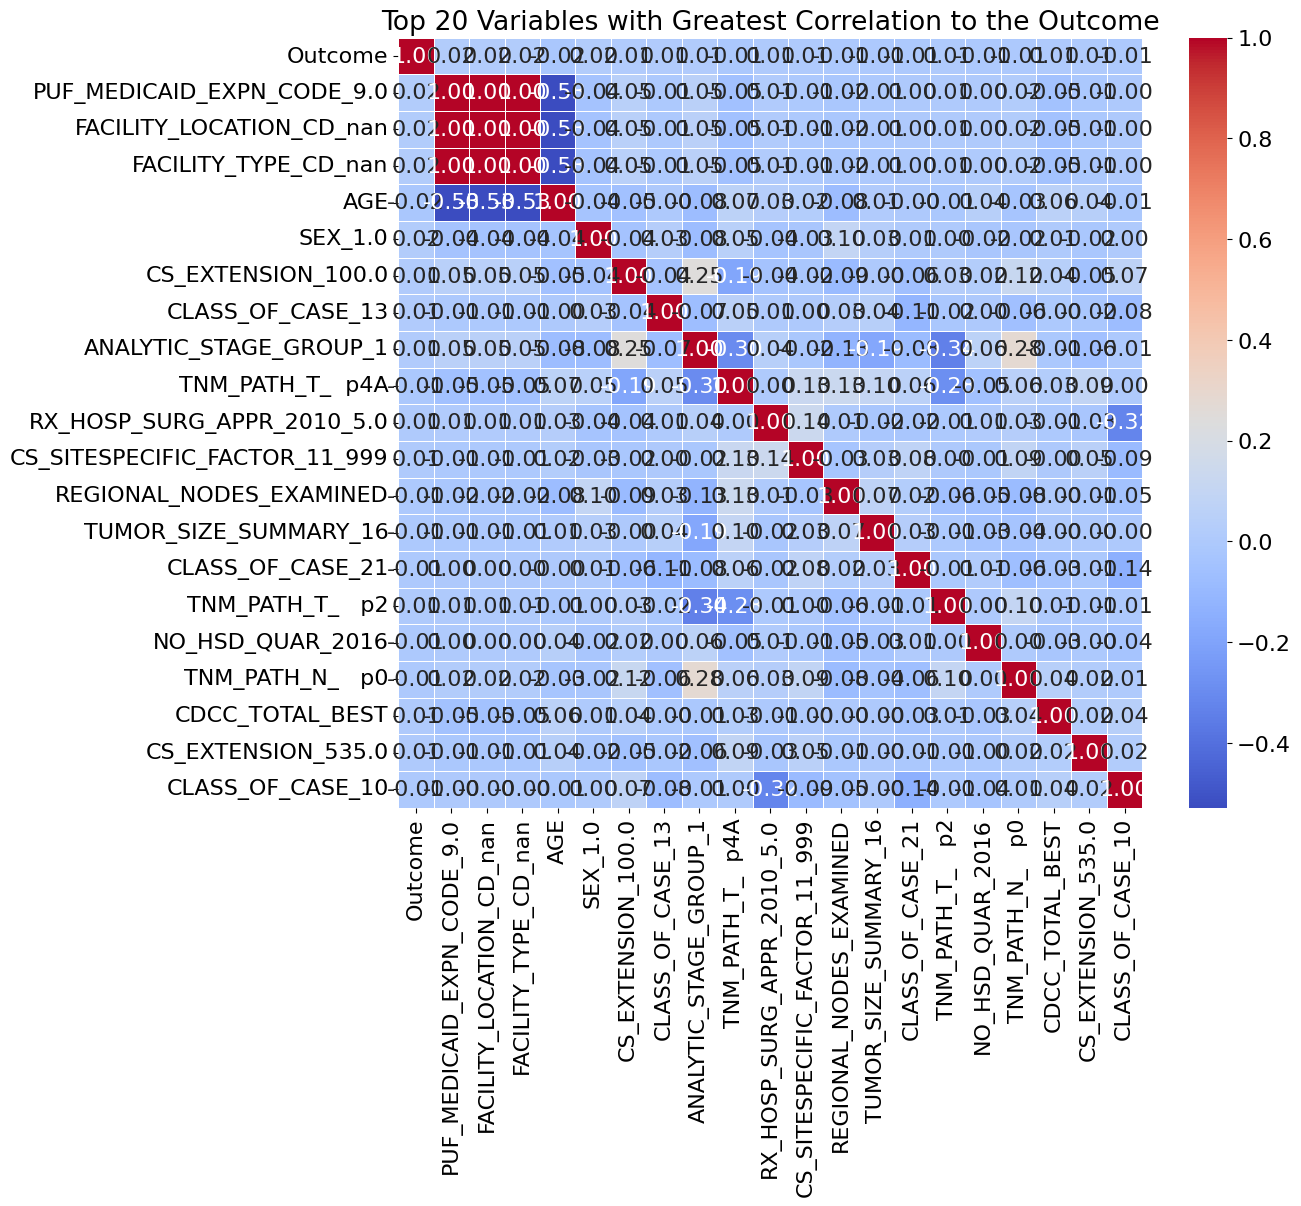

In [11]:
# Plot the covariance heatmap after feature reduction (or after preprocessing if feature reduction was not performed)
plot_covariance_heatmap(X_train, y_train, top_n=20)

In [12]:
# Optionally use PCA to transform the data features into principal component space
if use_PCA:
    X_train,X_test = pca_transform(X_train,X_test)

# Use SMOTE to resample the training data to make it more balanced
X_train,y_train = SMOTE_resample(X_train, X_test, y_train, y_test, sampling_strategy=0.2)

print('Data processing complete')
print('X_train shape: ',X_train.shape); print('X_test shape: ',X_test.shape); print('y_train shape: ',y_train.shape); print('y_test shape: ',y_test.shape)

# Save the variables to a file
with open(f'data/{experiment_name}_data_variables.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)

print('Final columns')
print(X_train.columns.tolist())



There are 295.0 or 1% positive examples of out 32764 samples in the training data.
There are 60.0 or 1% positive examples of out 8191 samples in the test data.


After SMOTE there are 6493.0 or 17% positive examples in the training data out of 38962 samples in the training data.
Data processing complete
X_train shape:  (38962, 57)
X_test shape:  (8191, 57)
y_train shape:  (38962,)
y_test shape:  (8191,)
Final columns
['AGE', 'CROWFLY', 'REGIONAL_NODES_POSITIVE', 'TUMOR_SIZE_SUMMARY_16', 'TUMOR_SIZE', 'DX_SURG_STARTED_DAYS', 'DX_DEFSURG_STARTED_DAYS', 'SURG_DISCHARGE_DAYS', 'REGIONAL_NODES_EXAMINED', 'NO_HSD_QUAR_00', 'NO_HSD_QUAR_2016', 'UR_CD_03', 'CDCC_TOTAL_BEST', 'SEX_1.0', 'FACILITY_TYPE_CD_nan', 'FACILITY_LOCATION_CD_2.0', 'FACILITY_LOCATION_CD_5.0', 'FACILITY_LOCATION_CD_nan', 'PUF_MULT_SOURCE_0', 'PUF_MULT_SOURCE_1', 'INSURANCE_STATUS_1.0', 'INSURANCE_STATUS_3.0', 'PUF_MEDICAID_EXPN_CODE_9.0', 'SEQUENCE_NUMBER_1.0', 'SEQUENCE_NUMBER_2.0', 'CLASS_OF_CASE_10', 'CLASS_OF_CASE_13

In [13]:
print(X_train.columns.tolist())

['AGE', 'CROWFLY', 'REGIONAL_NODES_POSITIVE', 'TUMOR_SIZE_SUMMARY_16', 'TUMOR_SIZE', 'DX_SURG_STARTED_DAYS', 'DX_DEFSURG_STARTED_DAYS', 'SURG_DISCHARGE_DAYS', 'REGIONAL_NODES_EXAMINED', 'NO_HSD_QUAR_00', 'NO_HSD_QUAR_2016', 'UR_CD_03', 'CDCC_TOTAL_BEST', 'SEX_1.0', 'FACILITY_TYPE_CD_nan', 'FACILITY_LOCATION_CD_2.0', 'FACILITY_LOCATION_CD_5.0', 'FACILITY_LOCATION_CD_nan', 'PUF_MULT_SOURCE_0', 'PUF_MULT_SOURCE_1', 'INSURANCE_STATUS_1.0', 'INSURANCE_STATUS_3.0', 'PUF_MEDICAID_EXPN_CODE_9.0', 'SEQUENCE_NUMBER_1.0', 'SEQUENCE_NUMBER_2.0', 'CLASS_OF_CASE_10', 'CLASS_OF_CASE_13', 'CLASS_OF_CASE_14', 'CLASS_OF_CASE_21', 'CLASS_OF_CASE_22', 'PRIMARY_SITE_C019', 'PRIMARY_SITE_C079', 'GRADE_3.0', 'TNM_CLIN_T_   c1', 'TNM_CLIN_STAGE_GROUP_   1', 'TNM_CLIN_STAGE_GROUP_  4A', 'TNM_PATH_T_   p1', 'TNM_PATH_T_   p2', 'TNM_PATH_T_  p4A', 'TNM_PATH_N_   p0', 'TNM_PATH_M_   pX', 'ANALYTIC_STAGE_GROUP_1', 'CS_EXTENSION_100.0', 'CS_EXTENSION_300.0', 'CS_EXTENSION_535.0', 'RX_HOSP_SURG_PRIM_SITE_0.0', 'RX_H

In [14]:
final_features = [
    'AGE', # keep this, allow user to enter "Age" 
    'CROWFLY', # keep this, allow user to enter "Patient's residence distance from nearest hospital in miles (estimate is okay)" 
    'REGIONAL_NODES_POSITIVE', # keep this, allow user to enter "Number of positive regional nodes" 
    'TUMOR_SIZE_SUMMARY_16', # remove this... it's just one-hot encoding of tumor size 
    'TUMOR_SIZE', # keep this, allow user to enter "Tumor Size (size of largest dimension in mm)" 
    'DX_SURG_STARTED_DAYS', # keep this, allow user to enter "Number of days from diagnosis to first surgical procedure" 
    'DX_DEFSURG_STARTED_DAYS', # keep this, allow user to enter "Number of days from diagnosis to definitive surgical resection of primary site" 
    'SURG_DISCHARGE_DAYS', # keep this, allow user to enter "Number of days from surgery to discharge" 
    'REGIONAL_NODES_EXAMINED', # keep this, allow user to enter "Number of regional nodes examined" 
    # 'NO_HSD_QUAR_00', # remove this... it's the percentage of people in the census tract with no high school diploma in 2000 
    # 'NO_HSD_QUAR_2016', # remove this... it's the percentage of people in the census tract with no high school diploma in 2016 
    # 'UR_CD_03', # remove this... it's the urban-rural classification of the census tract 
    'CDCC_TOTAL_BEST', # keep this, allow user to select from a dropdown list "Charlson/Deyo comorbidity score", see note below 
    'SEX_1.0', # keep this, allow user to select from M or F or other, M means SEX_1.0 is positive, F means negative, other means leave it blank 
    # 'FACILITY_TYPE_CD_nan', # remove this... it's just one-hot encoding of facility type left blank 
    'FACILITY_LOCATION_CD_2.0', # keep this, user should select state from a dropdown, see note on facility location below 'FACILITY_LOCATION_CD_5.0', # see note on facility location below 
    'FACILITY_LOCATION_CD_nan', # see note on facility location below 
    'PUF_MULT_SOURCE_0', # keep this, allow user to select from two options "Was the patient treated at multiple CoC-accredited (Commission of Cancer) facilities", see note below 
    # 'PUF_MULT_SOURCE_1', # keep this, same as above, if user selects "Yes", this will be 1, if "No", this will be 0 
    'INSURANCE_STATUS_1.0', # keep this, user should select patient insurance from a dropdown, see note below 
    'INSURANCE_STATUS_3.0', # see note below 
    # 'PUF_MEDICAID_EXPN_CODE_9.0', # remove this 
    'SEQUENCE_NUMBER_1.0', # keep this, allow user to enter "How many primary cancers has the patient had before this current HNSCC primary" and use the answer to map to a code, see note below 
    'SEQUENCE_NUMBER_2.0', # same as above 
    # 'CLASS_OF_CASE_10', # remove this... it's just one-hot encoding of class of case, indicating whether or not to treat at this facility 
    # 'CLASS_OF_CASE_13', # remove this... it's just one-hot encoding of class of case 
    # 'CLASS_OF_CASE_14', # remove this... it's just one-hot encoding of class of case 
    # 'CLASS_OF_CASE_21', # remove this... it's just one-hot encoding of class of case 
    # 'CLASS_OF_CASE_22', # remove this... it's just one-hot encoding of class of case 
    # 'PRIMARY_SITE_C019', # remove this... it's just one-hot encoding of primary site 
    # 'PRIMARY_SITE_C079', # remove this... it's just one-hot encoding of primary site 
    'GRADE_3.0', # keep this, allow user to select from a dropdown list "Tumor Grade", see note below 
    'TNM_CLIN_T_   c1', # keep this, allow user to select from a dropdown list "Clinical T stage", see note below 
    'TNM_CLIN_STAGE_GROUP_   1', # keep this, allow user to select from a dropdown list "Clinical Stage Group", see note below 
    'TNM_CLIN_STAGE_GROUP_  4A', # same as above 
    'TNM_PATH_T_   p1', # keep this, allow user to select from a dropdown list "Pathological T stage", see note below 
    'TNM_PATH_T_   p2', # same as above 
    'TNM_PATH_T_  p4A', # same as above 
    'TNM_PATH_N_   p0', # keep this, allow user to select from a dropdown list "Pathological N stage", see note below 
    'TNM_PATH_M_   pX', # keep this, allow user to select from a dropdown list "Pathological M stage", see note below 
    'ANALYTIC_STAGE_GROUP_1', # keep this, allow user to select from a dropdown list "Overall AJCC Stage Group", see note below 
    # 'CS_EXTENSION_100.0', # remove this... it's just one-hot encoding of CS extension which is a deprecated variable 
    # 'CS_EXTENSION_300.0', # remove this... it's just one-hot encoding of CS extension which is a deprecated variable 
    # 'CS_EXTENSION_535.0', # remove this... it's just one-hot encoding of CS extension which is a deprecated variable 
    # 'RX_HOSP_SURG_PRIM_SITE_0.0', # remove this... it's just one-hot encoding of the primary surgical procedure 
    # 'RX_HOSP_SURG_PRIM_SITE_42.0', # remove this... it's just one-hot encoding of the primary surgical procedure 
    'RX_HOSP_SURG_APPR_2010_1.0', # keep this, allow user to select from a dropdown list "Surgical approach for primary site", see note below 
    'RX_HOSP_SURG_APPR_2010_5.0', # same as above 
    # 'LN_SIZE_0.0', # remove this... it's just one-hot encoding of a deprecated variable 
    # 'CS_SITESPECIFIC_FACTOR_4_0.0', # remove this... it's just one-hot encoding of a deprecated variable 
    # 'HISTOLOGY_8071.0', # remove this... it's just one-hot encoding of histology 
    # 'CS_SITESPECIFIC_FACTOR_9_10.0', # remove this... it's just one-hot encoding of a deprecated variable 
    # 'CS_SITESPECIFIC_FACTOR_9_988.0', # remove this... it's just one-hot encoding of a deprecated variable 
    # 'CS_SITESPECIFIC_FACTOR_11_999', # remove this... it's just one-hot encoding of a deprecated variable 
    # 'CS_SITESPECIFIC_FACTOR_10_988.0', # remove this... it's just one-hot encoding of a deprecated variable 
    # 'CS_SITESPECIFIC_FACTOR_10_998.0'# remove this... it's just one-hot encoding of a deprecated variable 
    ] 

print('Manually curating final selected features for clinical reproducibility:')
X_train = X_train[final_features]
X_test = X_test[final_features]
print('Final columns')
print(X_train.columns.tolist())
print(f'X_train and X_test now have {X_train.shape[1]} features each from the manual feature curation.')

Manually curating final selected features for clinical reproducibility:
Final columns
['AGE', 'CROWFLY', 'REGIONAL_NODES_POSITIVE', 'TUMOR_SIZE_SUMMARY_16', 'TUMOR_SIZE', 'DX_SURG_STARTED_DAYS', 'DX_DEFSURG_STARTED_DAYS', 'SURG_DISCHARGE_DAYS', 'REGIONAL_NODES_EXAMINED', 'CDCC_TOTAL_BEST', 'SEX_1.0', 'FACILITY_LOCATION_CD_2.0', 'FACILITY_LOCATION_CD_nan', 'PUF_MULT_SOURCE_0', 'INSURANCE_STATUS_1.0', 'INSURANCE_STATUS_3.0', 'SEQUENCE_NUMBER_1.0', 'SEQUENCE_NUMBER_2.0', 'GRADE_3.0', 'TNM_CLIN_T_   c1', 'TNM_CLIN_STAGE_GROUP_   1', 'TNM_CLIN_STAGE_GROUP_  4A', 'TNM_PATH_T_   p1', 'TNM_PATH_T_   p2', 'TNM_PATH_T_  p4A', 'TNM_PATH_N_   p0', 'TNM_PATH_M_   pX', 'ANALYTIC_STAGE_GROUP_1', 'RX_HOSP_SURG_APPR_2010_1.0', 'RX_HOSP_SURG_APPR_2010_5.0']
X_train and X_test now have 30 features each from the manual feature curation.


In [15]:
'''
Select 5 algorithms which can take normalized continuous variables and one-hot encoded categorical variables and output a probability
    1. XGBoost (Extreme Gradient Boosting)
    2. SGD Logistic Regression
    3. Logistic Regression
    4. CatBoost
    5. SVC
    (6.) LightGBM - too much memory requirement
    (7.) Neural Networks - too computationally expensive
    (8.) Gradient Boosting Classifier (e.g., scikit-learn's GradientBoostingClassifier) - too computationally expensive
Bootstrapped nested k-fold cross-validation (100-fold bootstrap, k=5, score should be the ROC-AUC score)
For the nested part, select a random range of hyperparameters appropriate for each of the 5 algorithms, with 20 different hyperparameter combinations total per algorithm
Plot progress bars showing training progress
Meh - Plot one bar plot per algorithm of ROC-AUC vs training param combination (thus the x-axis should have 20 ticks)
Print out the best hyperparameter combinations for each algorithm
Use stacking to get a single aggregate score based on all the 5 models with the best hyperparameter scores
Display Results
    Plot ROC-AUC plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score
    Plot bar plot showing the best bootstrapped nested k-fold cross-validation (ROC-AUC) score of each of the 5 algorithms + the 1 stacking algorithm score with error bars giving the 95% CI from bootstrapping
    Convert label probability into binary label (>=0.5 = 1, <0.5 = 0)
    Use binary labels to get accuracy, sensitivity, specificity, F1-score, and plot confusion matrix
Retrain the 5 models (with best hyperparams) and stacked model on the full train dataset (with progress bar)
Save the final trained 5 models and stacked model
    '''
# # Load the variables back from the file
# with open(f'{experiment_name}_data_variables.pkl', 'rb') as f:
#     X_train, X_test, y_train, y_test = pickle.load(f)

X_small = X_train[:500] # small version for testing
y_small = y_train[:500].ravel() # small version for testing

# Dictionary to collect all_models from each iteration
all_models = {}

# Iterate over each sub-dictionary in models_hyperparams
for model_name, model_hyperparams in models_hyperparams.items():
    save_filename = f'models/{experiment_name}_{model_name}_results_and_cv_model.pkl'
    
    # Check if this model's combined file already exists, if so, load it
    try:
        with open(save_filename, 'rb') as file:
            combined_data = pickle.load(file)
        results = combined_data["results"]
        model = combined_data["model"]
        print(f"Loaded saved combined file for {model_name}")
    except:
        # If not found, process, save, and combine this model and results
        if use_mini_dataset:
            results, model = process_and_save_combined(model_name, model_hyperparams, X_small, y_small, n_bootstraps_for_training, num_k_fold_splits, experiment_name)
        else:
            results, model = process_and_save_combined(model_name, model_hyperparams, X_train, y_train, n_bootstraps_for_training, num_k_fold_splits, experiment_name)
        print(f"Processed, saved, and combined for {model_name}")
    
    # Collect this model
    all_models.update(model)


Training XGBoost:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best parameters for XGBoost: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}
Processed, saved, and combined for XGBoost


Training CatBoost:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best parameters for CatBoost: {'iterations': 200, 'depth': 5, 'learning_rate': 0.1}
Processed, saved, and combined for CatBoost


Training Logistic Regression:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2'}
Processed, saved, and combined for Logistic Regression


Training SGD Logistic Regression:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Best parameters for SGD Logistic Regression: {'penalty': 'elasticnet'}
Processed, saved, and combined for SGD Logistic Regression


Training Gradient Boosting:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Best parameters for Gradient Boosting: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5}
Processed, saved, and combined for Gradient Boosting


In [16]:
# Create a stacked model which incorporates all models
stacked_model = stack_models(all_models)
trained_stacked_model = None
trained_all_models = None

# Check if this model's combined file already exists, if so, load it
save_filename = f'models/{experiment_name}_trained_stacked_model.pkl'
try:
    # Load stacked_model
    with open(f'/models/{experiment_name}_trained_stacked_model.pkl', 'rb') as file:
        trained_stacked_model = pickle.load(file)

    # Load all_models
    with open(f'/models/{experiment_name}_trained_all_models.pkl', 'rb') as file:
        trained_all_models = pickle.load(file)
    print(f"Loaded saved trained models for {experiment_name}")
except:
    print('Retraining all models plus stacked model on the full training dataset...')
    if use_mini_dataset:
        trained_stacked_model, trained_all_models = retrain_models(stacked_model, all_models, 
                                                               X_small, y_small)
    else:
        trained_stacked_model, trained_all_models = retrain_models(stacked_model, all_models, 
                                                               X_train, y_train)
    import cloudpickle # cloudpickle better than pickle for cross-version compatibility

    with open(f'models/{experiment_name}_trained_stacked_model.pkl', "wb") as f:
        cloudpickle.dump(trained_stacked_model, f)

    with open(f'models/{experiment_name}_trained_all_models.pkl', "wb") as f:
        cloudpickle.dump(trained_all_models, f)

    # # Save stacked_model
    # with open(f'models/{experiment_name}_trained_stacked_model.pkl', 'wb') as file:
    #     pickle.dump(trained_stacked_model, file)
    # # Save all_models
    # with open(f'models/{experiment_name}_trained_all_models.pkl', 'wb') as file:
    #     pickle.dump(trained_all_models, file)


Retraining all models plus stacked model on the full training dataset...


In [17]:
# # # Load the variables back from the file
# # with open('/data/data_variables.pkl', 'rb') as f:
# #     X_train, X_test, y_train, y_test = pickle.load(f)

# # # Load stacked_model
# # with open('/models/trained_stacked_model.pkl', 'rb') as file:
# #     trained_stacked_model = pickle.load(file)

# # # Load all_models
# # with open('/models/trained_all_models.pkl', 'rb') as file:
# #     trained_all_models = pickle.load(file)

# print('Training performance results')
# display_results(trained_stacked_model, trained_all_models, X_train, y_train, class_labels, target_fpr=0.5, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

# print('Testing performance results')
# display_results(trained_stacked_model, trained_all_models, X_test, y_test, class_labels, target_fpr=0.5, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

Training performance results


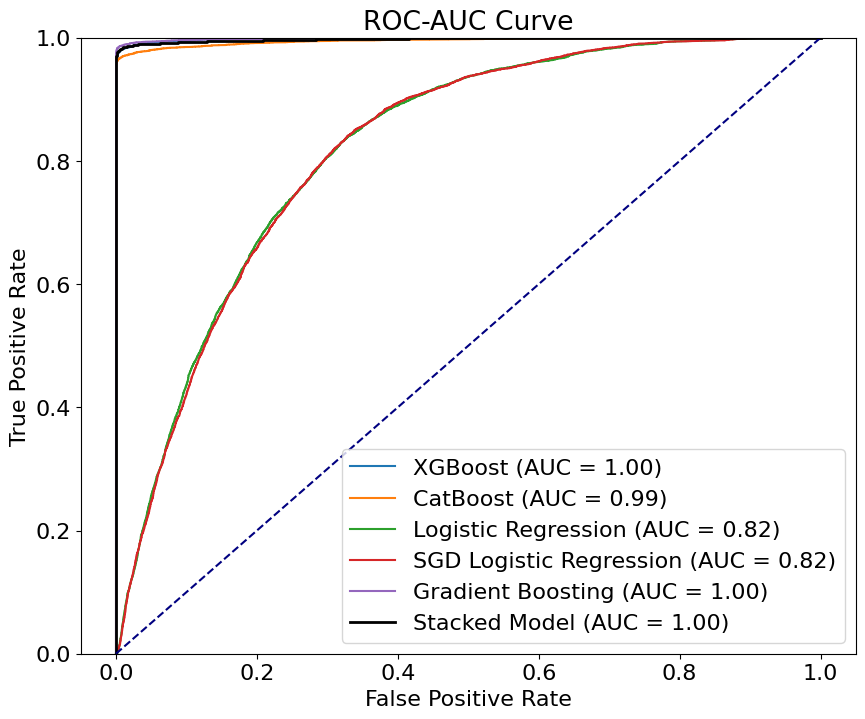

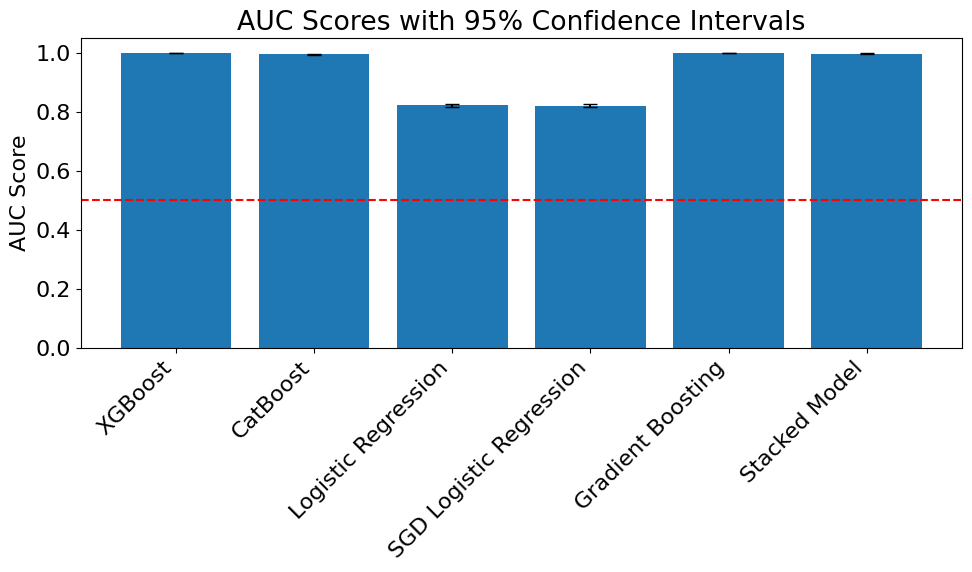

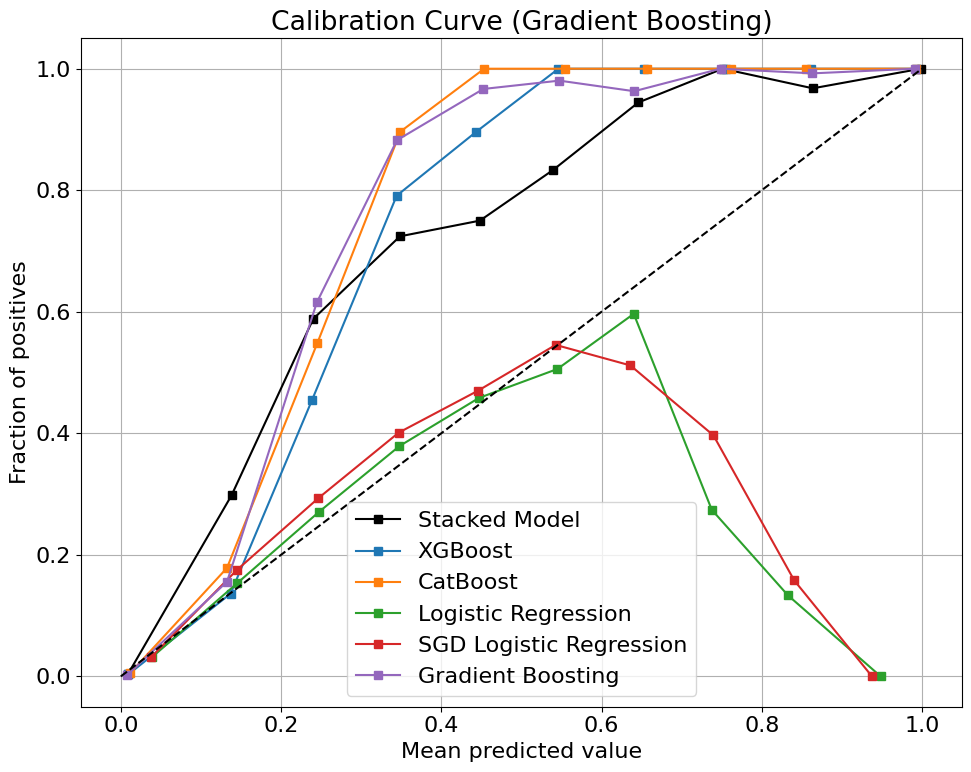

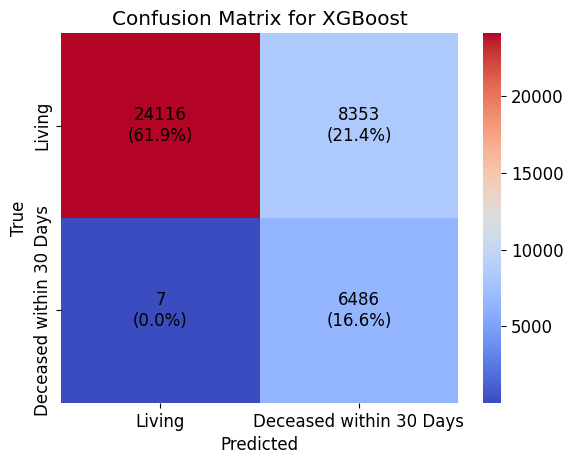


XGBoost:
AUC: 1.00 (95% CI: 1.00-1.00)
Accuracy: 0.79 (95% CI: 0.78-0.79)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.74 (95% CI: 0.74-0.75)
F1-Score: 0.61 (95% CI: 0.60-0.61)
Relative Risk: 1506.28 (95% CI: 945.95-3467.95)
Absolute Risk High: 0.4371 (95% CI: 0.4285-0.4437)
Absolute Risk Low: 0.0003 (95% CI: 0.0001-0.0005)
Attributable Risk: 0.4368 (95% CI: 0.4282-0.4434)
P-value for group comparison: 0.000000000


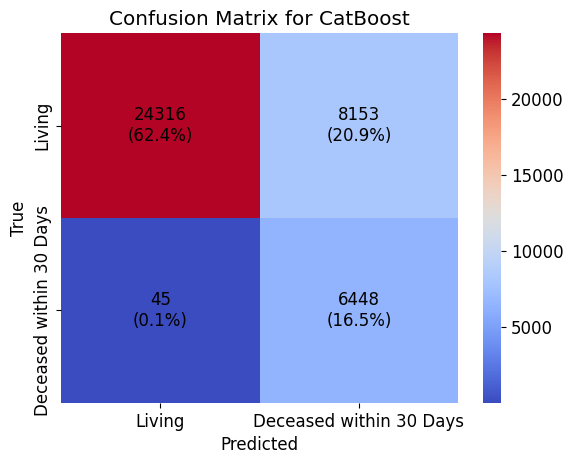


CatBoost:
AUC: 0.99 (95% CI: 0.99-1.00)
Accuracy: 0.79 (95% CI: 0.79-0.79)
Sensitivity: 0.99 (95% CI: 0.99-1.00)
Specificity: 0.75 (95% CI: 0.74-0.75)
F1-Score: 0.61 (95% CI: 0.60-0.62)
Relative Risk: 239.07 (95% CI: 181.44-369.40)
Absolute Risk High: 0.4416 (95% CI: 0.4339-0.4490)
Absolute Risk Low: 0.0018 (95% CI: 0.0012-0.0024)
Attributable Risk: 0.4398 (95% CI: 0.4319-0.4472)
P-value for group comparison: 0.000000000


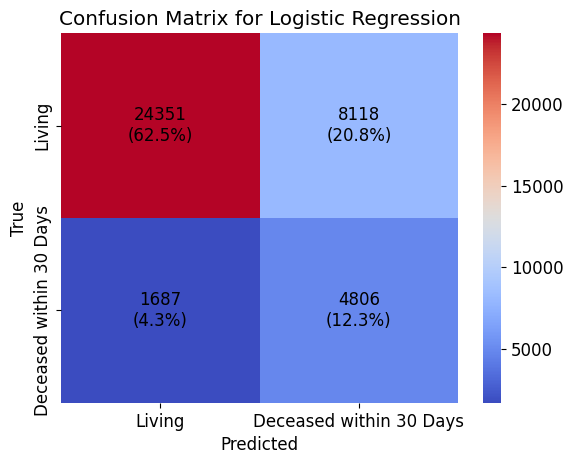


Logistic Regression:
AUC: 0.82 (95% CI: 0.82-0.83)
Accuracy: 0.75 (95% CI: 0.74-0.75)
Sensitivity: 0.74 (95% CI: 0.73-0.75)
Specificity: 0.75 (95% CI: 0.75-0.76)
F1-Score: 0.49 (95% CI: 0.49-0.50)
Relative Risk: 5.74 (95% CI: 5.48-6.11)
Absolute Risk High: 0.3719 (95% CI: 0.3637-0.3797)
Absolute Risk Low: 0.0648 (95% CI: 0.0611-0.0675)
Attributable Risk: 0.3071 (95% CI: 0.2987-0.3145)
P-value for group comparison: 0.000000000


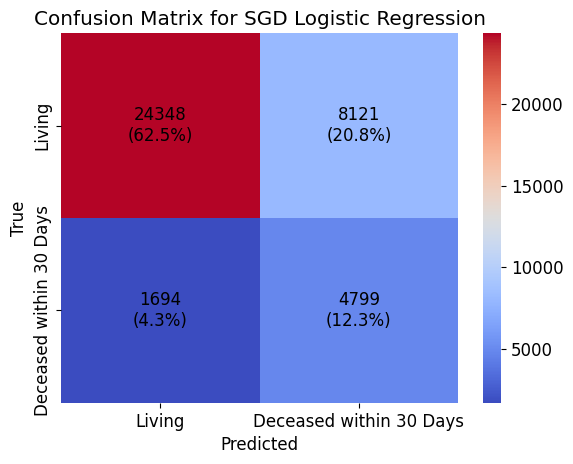


SGD Logistic Regression:
AUC: 0.82 (95% CI: 0.82-0.83)
Accuracy: 0.75 (95% CI: 0.74-0.75)
Sensitivity: 0.74 (95% CI: 0.73-0.75)
Specificity: 0.75 (95% CI: 0.75-0.75)
F1-Score: 0.49 (95% CI: 0.49-0.50)
Relative Risk: 5.71 (95% CI: 5.46-6.11)
Absolute Risk High: 0.3714 (95% CI: 0.3638-0.3792)
Absolute Risk Low: 0.0650 (95% CI: 0.0611-0.0679)
Attributable Risk: 0.3064 (95% CI: 0.2984-0.3141)
P-value for group comparison: 0.000000000


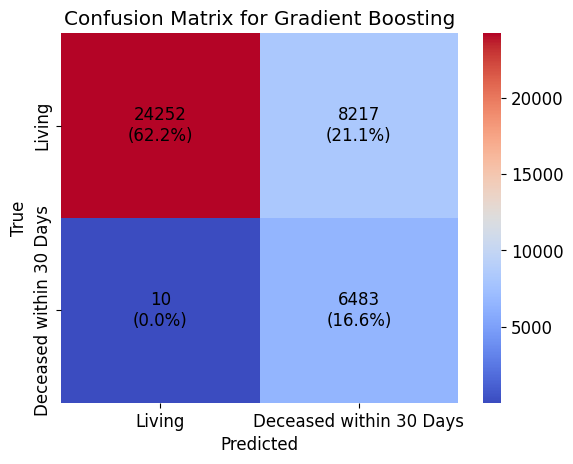


Gradient Boosting:
AUC: 1.00 (95% CI: 1.00-1.00)
Accuracy: 0.79 (95% CI: 0.79-0.79)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.75 (95% CI: 0.74-0.75)
F1-Score: 0.61 (95% CI: 0.60-0.62)
Relative Risk: 1070.00 (95% CI: 629.70-2410.70)
Absolute Risk High: 0.4410 (95% CI: 0.4328-0.4491)
Absolute Risk Low: 0.0004 (95% CI: 0.0002-0.0007)
Attributable Risk: 0.4406 (95% CI: 0.4324-0.4487)
P-value for group comparison: 0.000000000


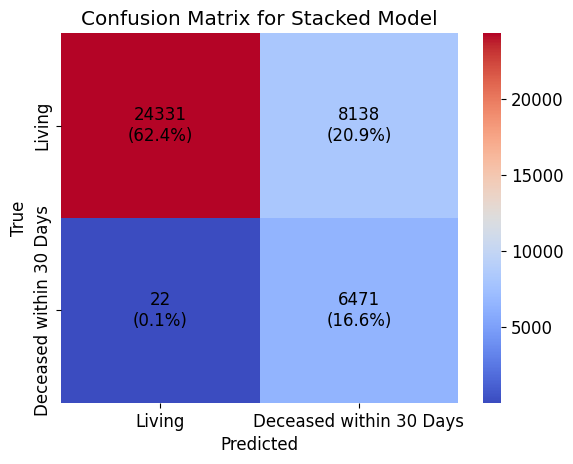


Stacked Model:
AUC: 1.00 (95% CI: 1.00-1.00)
Accuracy: 0.79 (95% CI: 0.79-0.79)
Sensitivity: 1.00 (95% CI: 1.00-1.00)
Specificity: 0.75 (95% CI: 0.75-0.75)
F1-Score: 0.61 (95% CI: 0.61-0.62)
Relative Risk: 490.32 (95% CI: 334.64-745.08)
Absolute Risk High: 0.4429 (95% CI: 0.4353-0.4503)
Absolute Risk Low: 0.0009 (95% CI: 0.0006-0.0013)
Attributable Risk: 0.4420 (95% CI: 0.4346-0.4494)
P-value for group comparison: 0.000000000
Testing performance results


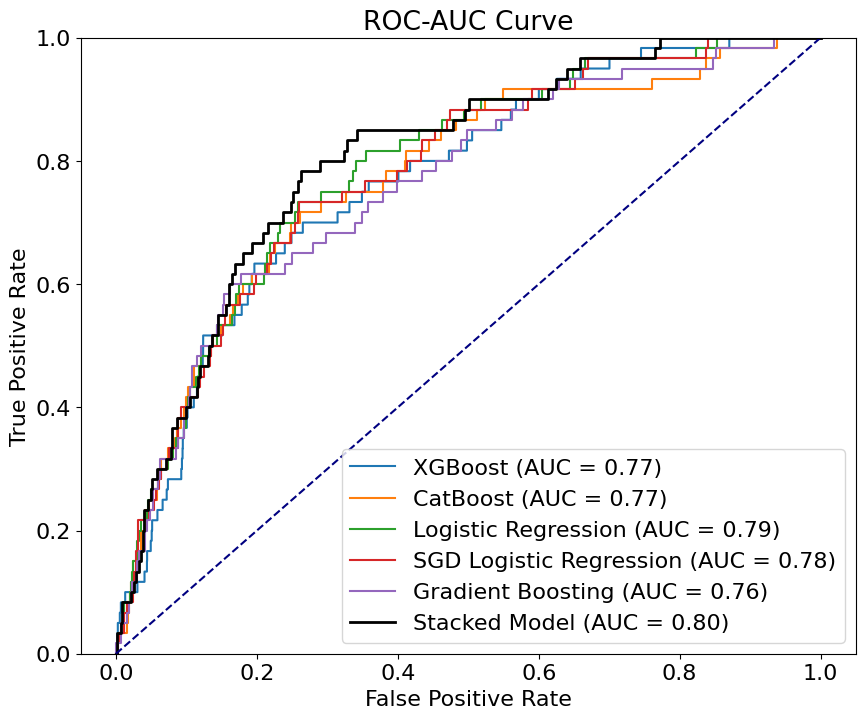

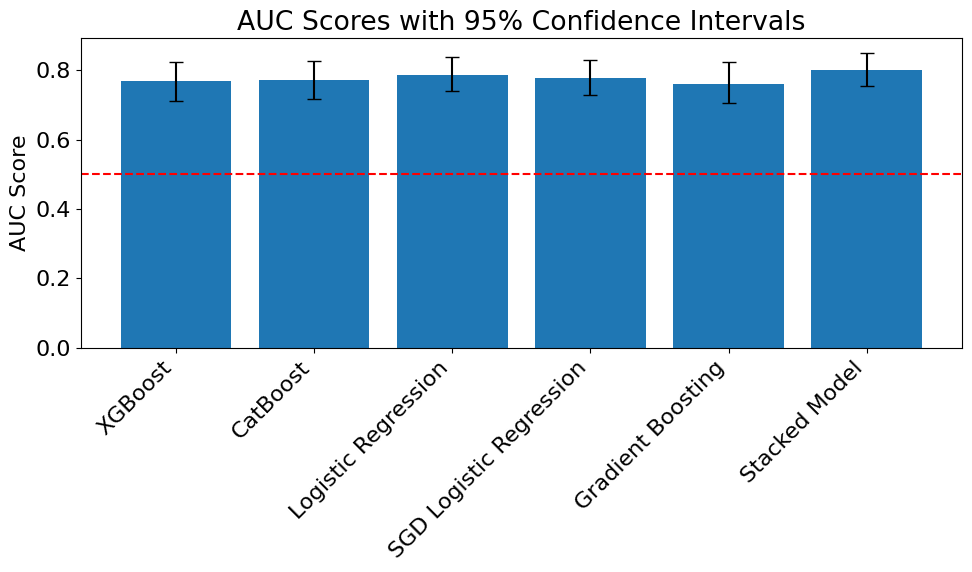

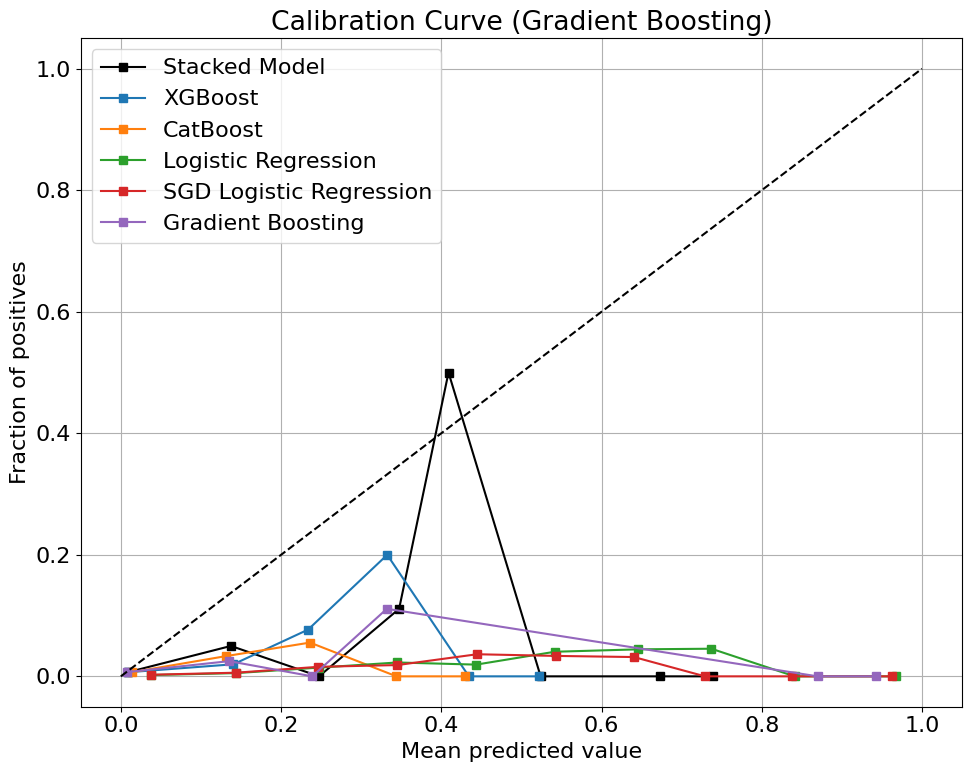

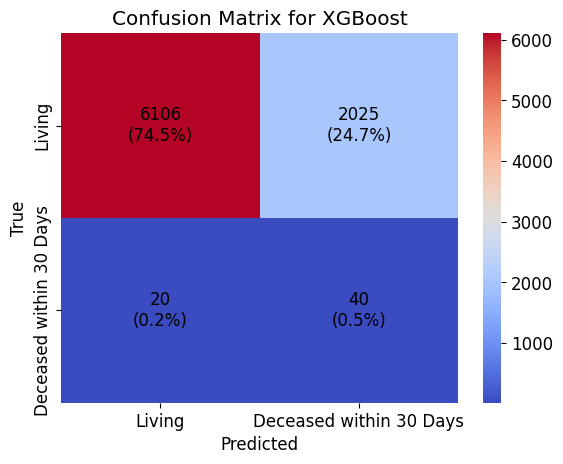


XGBoost:
AUC: 0.77 (95% CI: 0.71-0.82)
Accuracy: 0.75 (95% CI: 0.74-0.76)
Sensitivity: 0.67 (95% CI: 0.56-0.78)
Specificity: 0.75 (95% CI: 0.74-0.76)
F1-Score: 0.04 (95% CI: 0.03-0.05)
Relative Risk: 5.93 (95% CI: 3.84-10.18)
Absolute Risk High: 0.0194 (95% CI: 0.0149-0.0253)
Absolute Risk Low: 0.0033 (95% CI: 0.0020-0.0045)
Attributable Risk: 0.0161 (95% CI: 0.0114-0.0227)
P-value for group comparison: 0.000000000


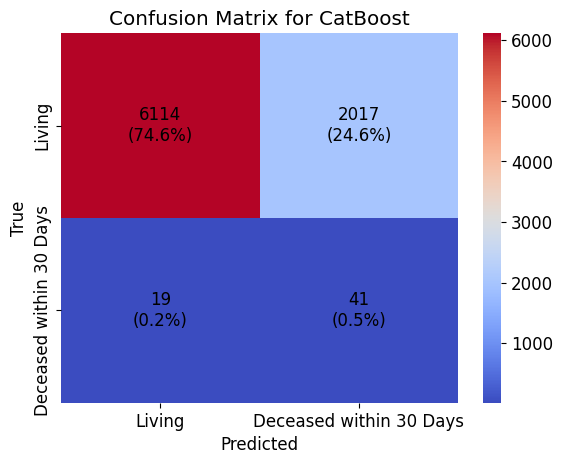


CatBoost:
AUC: 0.78 (95% CI: 0.72-0.83)
Accuracy: 0.75 (95% CI: 0.74-0.76)
Sensitivity: 0.69 (95% CI: 0.57-0.79)
Specificity: 0.75 (95% CI: 0.74-0.76)
F1-Score: 0.04 (95% CI: 0.03-0.05)
Relative Risk: 6.43 (95% CI: 4.09-11.27)
Absolute Risk High: 0.0199 (95% CI: 0.0156-0.0263)
Absolute Risk Low: 0.0031 (95% CI: 0.0019-0.0045)
Attributable Risk: 0.0168 (95% CI: 0.0122-0.0235)
P-value for group comparison: 0.000000000


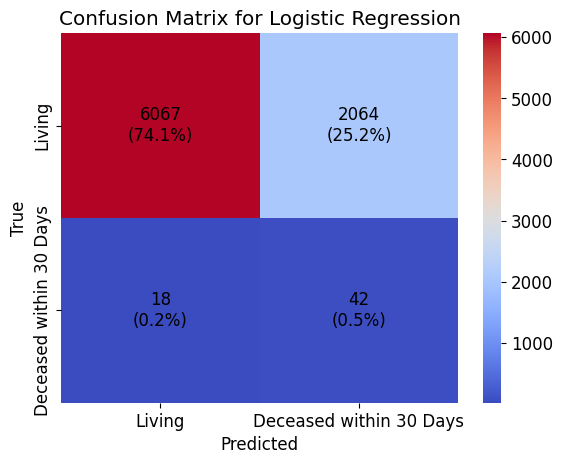


Logistic Regression:
AUC: 0.79 (95% CI: 0.74-0.84)
Accuracy: 0.75 (95% CI: 0.74-0.75)
Sensitivity: 0.70 (95% CI: 0.58-0.81)
Specificity: 0.75 (95% CI: 0.74-0.75)
F1-Score: 0.04 (95% CI: 0.03-0.05)
Relative Risk: 6.74 (95% CI: 4.01-12.44)
Absolute Risk High: 0.0199 (95% CI: 0.0153-0.0260)
Absolute Risk Low: 0.0030 (95% CI: 0.0018-0.0043)
Attributable Risk: 0.0170 (95% CI: 0.0115-0.0233)
P-value for group comparison: 0.000000000


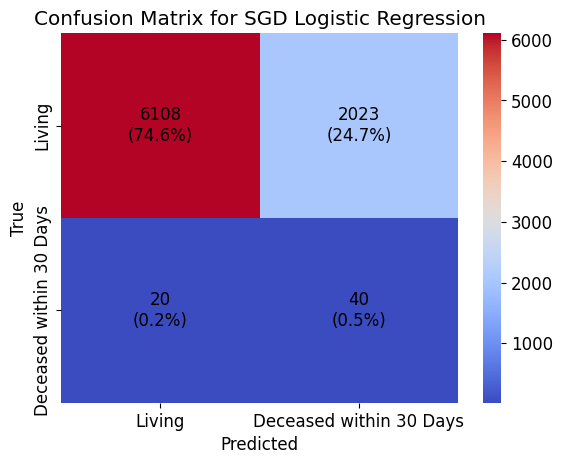


SGD Logistic Regression:
AUC: 0.78 (95% CI: 0.73-0.83)
Accuracy: 0.75 (95% CI: 0.74-0.76)
Sensitivity: 0.67 (95% CI: 0.56-0.78)
Specificity: 0.75 (95% CI: 0.74-0.76)
F1-Score: 0.04 (95% CI: 0.03-0.05)
Relative Risk: 5.94 (95% CI: 3.65-10.71)
Absolute Risk High: 0.0194 (95% CI: 0.0144-0.0248)
Absolute Risk Low: 0.0033 (95% CI: 0.0020-0.0045)
Attributable Risk: 0.0161 (95% CI: 0.0106-0.0224)
P-value for group comparison: 0.000000000


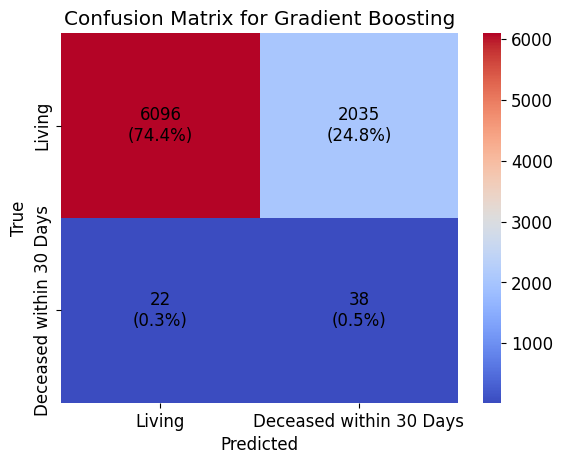


Gradient Boosting:
AUC: 0.77 (95% CI: 0.70-0.82)
Accuracy: 0.75 (95% CI: 0.74-0.76)
Sensitivity: 0.64 (95% CI: 0.51-0.76)
Specificity: 0.75 (95% CI: 0.74-0.76)
F1-Score: 0.04 (95% CI: 0.03-0.05)
Relative Risk: 5.10 (95% CI: 3.05-9.43)
Absolute Risk High: 0.0183 (95% CI: 0.0133-0.0251)
Absolute Risk Low: 0.0036 (95% CI: 0.0021-0.0052)
Attributable Risk: 0.0147 (95% CI: 0.0089-0.0222)
P-value for group comparison: 0.000000000


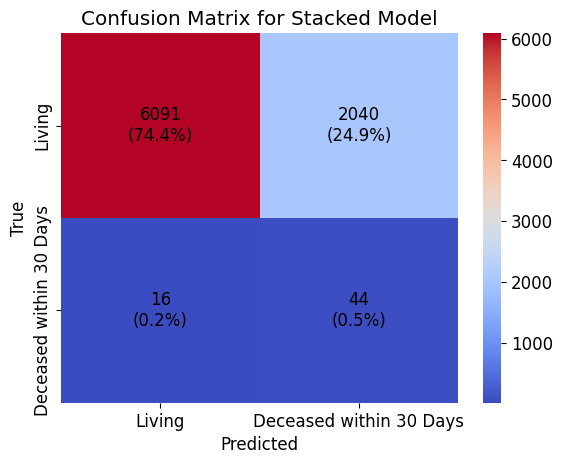


Stacked Model:
AUC: 0.80 (95% CI: 0.75-0.85)
Accuracy: 0.75 (95% CI: 0.74-0.76)
Sensitivity: 0.73 (95% CI: 0.61-0.83)
Specificity: 0.75 (95% CI: 0.74-0.76)
F1-Score: 0.04 (95% CI: 0.03-0.05)
Relative Risk: 8.06 (95% CI: 4.71-14.09)
Absolute Risk High: 0.0211 (95% CI: 0.0163-0.0277)
Absolute Risk Low: 0.0026 (95% CI: 0.0016-0.0040)
Attributable Risk: 0.0185 (95% CI: 0.0132-0.0254)
P-value for group comparison: 0.000000000


In [18]:
# Target FPR 0.25

print('Training performance results')
display_results(trained_stacked_model, trained_all_models, X_train, y_train, class_labels, target_fpr=0.25, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

print('Testing performance results')
display_results(trained_stacked_model, trained_all_models, X_test, y_test, class_labels, target_fpr=0.25, plot_ci=False, n_bootstraps = n_bootstraps_for_results)

In [19]:
def subgroup_analysis(subgroup_column, variable_type, trained_stacked_model, trained_all_models, X_test, y_test):
    if not isinstance(X_test, pd.DataFrame):
        raise ValueError("X_test must be a pandas DataFrame.")

    # Initializing variables to store results
    subgroups = []
    model_names = ['Stacked Model'] + list(trained_all_models.keys())
    auc_scores_dict = {model_name: [] for model_name in model_names}
    
    def compute_auc_scores(subgroup_indices):
        for model_name in auc_scores_dict.keys():
            if model_name == 'Stacked Model':
                model = trained_stacked_model
            else:
                model = trained_all_models[model_name]
            auc_score = roc_auc_score(y_test[subgroup_indices], model.predict_proba(X_test.iloc[subgroup_indices])[:, 1])
            auc_scores_dict[model_name].append(auc_score)
    
    if variable_type == 'continuous':
        split_value = 0  # Assuming normalization to mean=0
        
        # Splitting the data into subgroups
        index_below = np.where(X_test[subgroup_column] <= split_value)[0]
        index_above = np.where(X_test[subgroup_column] > split_value)[0]

        # Compute AUC for each subgroup
        compute_auc_scores(index_below)
        compute_auc_scores(index_above)
        
        subgroups = ['Below or Equal Mean', 'Above Mean']

    elif variable_type == 'categorical':
        categories = [col.split('_')[-1] for col in X_test.columns if subgroup_column in col]
        others_auc_scores = {model_name: [] for model_name in model_names}
        
        for category in categories:
            column_name = f"{subgroup_column}_{category}"
            if column_name in X_test.columns:
                index_cat = np.where(X_test[column_name] == 1)[0]

                # Compute AUC for the subgroup or add to "Other"
                if len(index_cat) / len(X_test) < 0.01:
                    for model_name in others_auc_scores.keys():
                        others_auc_scores[model_name].append(roc_auc_score(y_test[index_cat], trained_all_models[model_name].predict_proba(X_test.iloc[index_cat])[:, 1] if model_name != 'Stacked Model' else trained_stacked_model.predict_proba(X_test.iloc[index_cat])[:, 1]))
                else:
                    compute_auc_scores(index_cat)
                    subgroups.append(category)

        # Handle "Other" category
        if any(others_auc_scores[model_name] for model_name in model_names):
            subgroups.append("Other")
            for model_name, scores in others_auc_scores.items():
                auc_scores_dict[model_name].append(np.mean(scores))

    else:
        raise ValueError("variable_type must be either 'continuous' or 'categorical'.")

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.1  # Width of each bar
    x = np.arange(len(subgroups))
    
    for i, model_name in enumerate(model_names):
        if model_name == 'Stacked Model':
            ax.bar(x - 0.2 + i*width, auc_scores_dict[model_name], width, color='black', label=model_name)
        else:
            ax.bar(x - 0.2 + i*width, auc_scores_dict[model_name], width, label=model_name)
    
    ax.set_xlabel('Subgroup')
    ax.set_ylabel('AUC')
    ax.set_title(f'AUC by Subgroup for {subgroup_column}')
    ax.set_xticks(x)
    ax.set_xticklabels(subgroups, rotation=45)
#     ax.legend()
    ax.legend(loc='lower center', fontsize='small')

    
    plt.tight_layout()
    plt.ylim([0,1.0])
    plt.show()

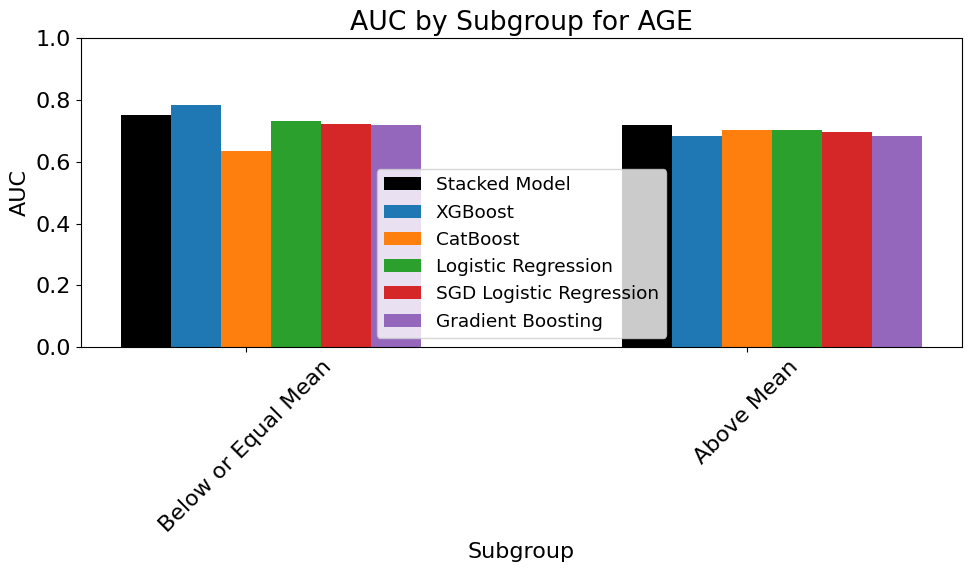

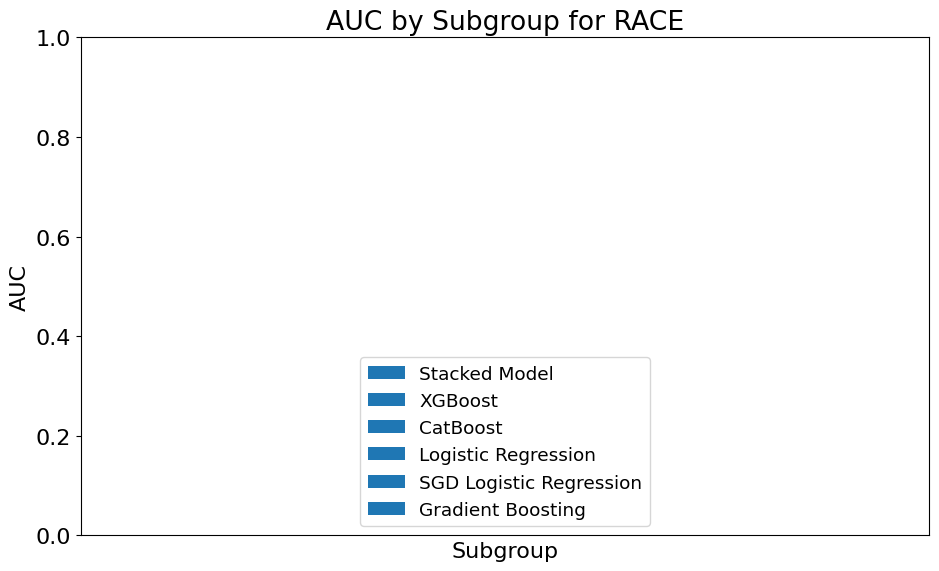

In [20]:
# For continuous variable AGE
subgroup_analysis('AGE', 'continuous', trained_stacked_model,trained_all_models, X_test, y_test)

# For categorical variable RACE
subgroup_analysis('RACE', 'categorical', trained_stacked_model,trained_all_models, X_test, y_test)

In [21]:
race_columns = [col for col in X_test.columns if "RACE_" in col]
print(race_columns)

[]


In [ ]:
save_filename = f'models/{experiment_name}_trained_stacked_model_shap.pkl'

if use_mini_dataset: 
    explainer, shap_values = model_interpretability(trained_stacked_model, X_small, y_small, save_filename)
else:
    explainer, shap_values = model_interpretability(trained_stacked_model, X_test, y_test, save_filename)

PermutationExplainer explainer:  18%|█▊        | 1461/8191 [02:10<08:46, 12.78it/s]

In [ ]:
# Record the end time
end_time = datetime.datetime.now()

# Calculate the total runtime
total_runtime = end_time - start_time

# Convert total runtime to a format of days, hours, minutes, and seconds
formatted_runtime = str(total_runtime).split('.')[0]  # Remove microseconds

print(f"Total runtime: {formatted_runtime}")

Total runtime: 1:14:36


In [ ]:
import cloudpickle

with open(f'models/{experiment_name}_trained_stacked_model.pkl', "wb") as f:
    cloudpickle.dump(trained_stacked_model, f)

with open(f'models/{experiment_name}_trained_all_models.pkl', "wb") as f:
    cloudpickle.dump(trained_all_models, f)

In [ ]:
experiment_name

'30d_mort_demo'